# 基于网页抓取的内容回答问题

## 1. 抓取一篇知乎高赞回答

In [2]:
from langchain.document_loaders import WebBaseLoader

In [3]:
loader = WebBaseLoader("https://zhuanlan.zhihu.com/p/597586623")
data = loader.load()

In [4]:
len(data)

1

## 2. 对网页中的文本进行分割

抓取的网页内容，包含27973个words，如果把全量文本作为prompt输入给大模型，超过大多数模型的支持的max_seq_len，即便模型支持如此大的序列长度，一次生成任务对算力的消耗也很惊人。

因此，更好的办法是，只把问题相关的内容文本提取出来，作为prompt输入给大模型。从已知内容，提取相似度的内容，比较成熟的技术是向量搜索。把全量内容存入向量数据库，然后针对用户的问题，在向量数据库中进行相似度搜索（similarity search）。

向量搜索一般在内存中进行。通常一次向量相似搜索的结果，只与原文中的部分内容相关。缩小搜索的范围，可以降低相似度搜索对内存的消耗。

文本分割（split），是缩小搜索范围的方法。把原文内容，按分隔符，以及指定长度，分割为若干片段。






In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    separators=["。", "、", "\n\n", "\n", " ", "", ],
    chunk_size = 500,
    chunk_overlap = 20,
    length_function = len,
    add_start_index = True,
)

In [6]:
docs = text_splitter.split_documents(data)
docs

[Document(page_content='通向AGI之路：大型语言模型（LLM）技术精要 - 知乎首发于深度学习前沿笔记切换模式写文章登录/注册通向AGI之路：大型语言模型（LLM）技术精要张俊林\u200b自然语言处理等 2 个话题下的优秀答主6,649 人赞同了该文章ChatGPT出现后惊喜或惊醒了很多人。惊喜是因为没想到大型语言模型（LLM,Large Language Model）效果能好成这样；惊醒是顿悟到我们对LLM的认知及发展理念，距离世界最先进的想法，差得有点远。我属于既惊喜又惊醒的那一批，也是典型的中国人，中国人善于自我反思，于是开始反思，而这篇文章正是反思的结果。实话实说，国内在LLM模型相关技术方面，此刻，距离最先进技术的差距进一步加大了。技术领先或技术差距这事情，我觉得要动态地以发展的眼光来看。在Bert出现之后的一到两年间，其实国内在这块的技术追赶速度还是很快的，也提出了一些很好的改进模型，差距拉开的分水岭应该是在 GPT 3.0出来之后，也就是2020年年中左右。在当时，其实只有很少的人觉察到：GPT 3.0它不仅仅是一项具体的技术，其实体现的是LLM应该往何处去的一个发展理念', metadata={'source': 'https://zhuanlan.zhihu.com/p/597586623', 'title': '通向AGI之路：大型语言模型（LLM）技术精要 - 知乎', 'description': 'ChatGPT出现后惊喜或惊醒了很多人。惊喜是因为没想到大型语言模型（LLM,Large Language Model）效果能好成这样；惊醒是顿悟到我们对LLM的认知及发展理念，距离世界最先进的想法，差得有点远。我属于既惊喜又惊醒的…', 'language': 'zh', 'start_index': 1}),
 Document(page_content='。自此之后，差距拉得越来越远，ChatGPT只是这种发展理念差异的一个自然结果。所以，我个人认为，抛开是否有财力做超大型LLM这个因素，如果单从技术角度看，差距主要来自于对LLM的认知以及未来应往何处去的发展理念的不同。国内被国外技术甩得越来越远，这个是事实，不承认也不行。前阵子网上很多人担忧说国内AI现在处于“危急存亡之秋”，我觉得倒也不至于这么严重。君不见，这

## 3. 文本转化为向量，存入向量数据库

为了便于针对问题的文本相似度搜索，需要将分割后的文本片段转化为向量，这个过程叫embeddings。
embeddings是深度学习常用的技术，每个LLM都训练了自己的embeddings model，基础算法基本都是word2vec。

本文采用MiniMax的Embeddings模型对文本做embed操作（只是为了使用客户的产品，没有倾向性）。

我们需要对embeddings后的向量进行存储，存储介质为向量数据库。用户后续输入的prompt，也会转化为向量，与向量数据库中的已有向量计算距离，取向量距离最短的N个向量，作为搜索结果。
原理如下图所示
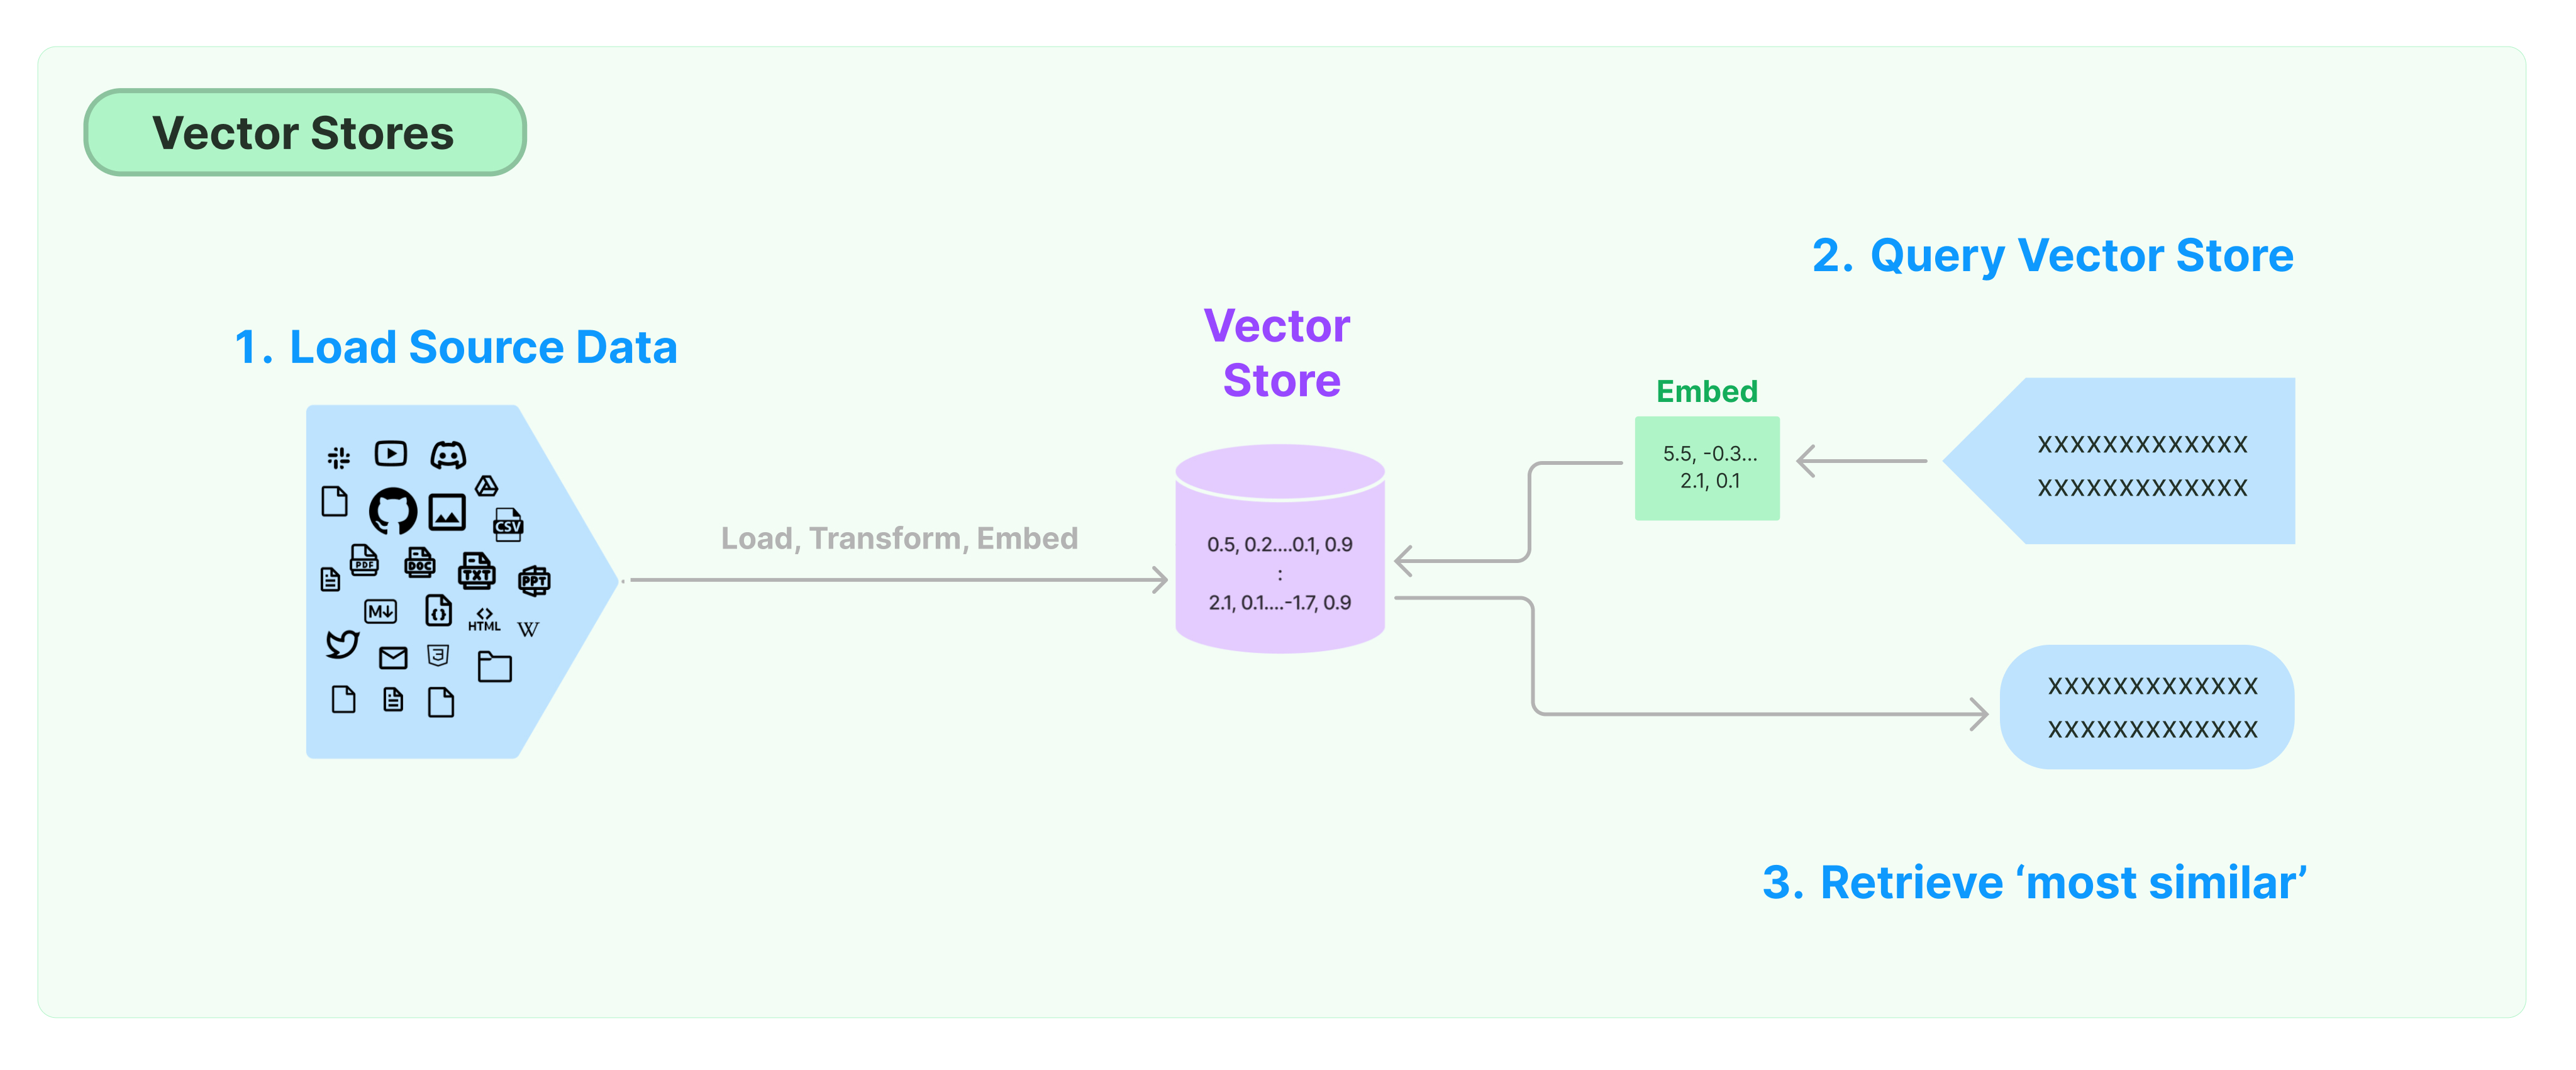

In [7]:
from langchain.embeddings import MiniMaxEmbeddings
embeddings = MiniMaxEmbeddings()

## 向量数据库的应用
Langchain集成了多种向量数据库，如FAISS，Chroma，以及Milvus等，也支持调用PGVector插件，使用PGsql的向量搜索能力。

In [26]:
from langchain.vectorstores import FAISS
from langchain.vectorstores import Chroma
from langchain.vectorstores import PGVector # PGVector需要提前部署，提供连接信息。
from langchain.vectorstores import Milvus  # Milvus需要提前部署，提供连接信息。

把文本转化为向量，存入db对象

In [29]:
# db = FAISS.from_documents(docs,embeddings)
db = Chroma.from_documents(docs,embeddings)
# db = PGVector.from_documents(embedding=embeddings,documents=docs,collection_name=COLLECTION_NAME,connection_string=CONNECTION_STRING)
# db = Milvus.from_documents(documents=docs,embedding=embeddings) 

## 提示词模版

In [30]:
from langchain import PromptTemplate
from langchain import LLMChain
from llm_wrapper import Baichuan

In [37]:
llm = Baichuan() # 初始化一个Baichuan大模型实例

In [32]:
template = """
    根据以下内容回答问题{doc}，不能自己编造内容。
    
    问题：{question}
"""

In [33]:
prompt = PromptTemplate(input_variables=['doc','question'],template=template)

In [34]:
chain = LLMChain(llm=llm,prompt=prompt)

## 相似度搜索

In [35]:
qustion = "NLP领域的中间任务是什么"
doc = db.similarity_search(query=qustion)
doc

[Document(page_content='。典型的中间任务包括：中文分词、词性标注、NER、句法分析、指代消解、语义Parser等，这类任务一般并不解决应用中的实际需求，大多数是作为那些解决实际需求任务的中间阶段或者辅助阶段存在的，比如几乎没有需求说，我要一个句法Parser，把这个句子的句法分析树给用户看看，用户不需要看到这些NLP的中间阶段处理结果，他只关心某个具体任务你有没有干好。“最终任务”包括比如文本分类、文本相似性计算、机器翻译、文本摘要等等，有很多。这类任务的特点是每个子领域都解决某个实际需求，任务结果基本能直接呈现给用户，比如用户确实存在给你一句英文，告诉他中文是什么的需求。按理说，“中间任务”就不应该出现，而之所以会存在，这是NLP技术发展水平不够高的一种体现。在技术发展早期阶段，因为当时的技术相对落后，很难一步做好有难度的最终任务。比如机器翻译，早期技术要做好机器翻译是很困难的，于是科研人员就把难题分而治之，分解成分词、词性标注、句法分析等各种中间阶段，先把每个中间阶段做好，然后再拼起来完成最终任务，这也是没办法的事情', metadata={'description': 'ChatGPT出现后惊喜或惊醒了很多人。惊喜是因为没想到大型语言模型（LLM,Large Language Model）效果能好成这样；惊醒是顿悟到我们对LLM的认知及发展理念，距离世界最先进的想法，差得有点远。我属于既惊喜又惊醒的…', 'language': 'zh', 'source': 'https://zhuanlan.zhihu.com/p/597586623', 'start_index': 2678, 'title': '通向AGI之路：大型语言模型（LLM）技术精要 - 知乎'}),
 Document(page_content='。典型的中间任务包括：中文分词、词性标注、NER、句法分析、指代消解、语义Parser等，这类任务一般并不解决应用中的实际需求，大多数是作为那些解决实际需求任务的中间阶段或者辅助阶段存在的，比如几乎没有需求说，我要一个句法Parser，把这个句子的句法分析树给用户看看，用户不需要看到这些NLP的中间阶段处理结果，他只关心某个具体任务你有没有干好。“最终任务”包括比如文本分类、文本相似性计算、机器翻译、文本摘要等等，有很多。这

## LLM问答

In [36]:
response = chain.run({'doc':doc,'question':qustion})
response

'NLP领域的中间任务通常是指一系列用于构建更高级别任务的基础步骤，例如中文分词、词性标注、命名实体识别(NER)、句法分析、指代消解以及语义解析等。这些任务本身可能不会直接满足应用中的实际需求，而是作为其他更高层次任务的中间环节或辅助过程。'